# Стратегия взаимодействия с клиентами фитнес-центра

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с клиентами на основе аналитических данных. 
Необходимо провести анализ и подготовить план действий по удержанию клиентов (на основе информации об оттоке клиентов).

В нашем распоряжении файл на основе клиентских анкет, содержащий данные пользователей фитнес-центра на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

•	Данные клиента за предыдущий до проверки факта оттока месяц:
*	'gender' — пол;
*	'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
*	'Partner' — сотрудник компании-партнёра клуба;
*	Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
*	'Phone' — наличие контактного телефона;
*	'Age' — возраст;
*	'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).

•	Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
*	'Contract_period' — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
*	'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
*	'Group_visits' — факт посещения групповых занятий;
*	'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
*	'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
*	'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.

•	'Churn' — факт оттока в текущем месяце.

**Цель исследования**:
* Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
* Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
* Проанализировать основные признаки, наиболее сильно влияющие на отток;
* Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
	* 1) выделить целевые группы клиентов;
	* 2) предложить меры по снижению оттока;
	* 3) определить другие особенности взаимодействия с клиентами.

**Оглавление проекта**
1. [Исследовательский анализ данных](#analysis)
    * 1.1. [Ознакомление с датасетом](#analysis_1)
    * 1.2. [Средние значения признаков по группам](#analysis_2)
    * 1.3. [Столбчатые гистограммы и распределения признаков по группам](#analysis_3)
    * 1.4. [Матрица корреляций](#analysis_4)
    * 1.5. [Вывод по данным](#conclusion_1)
2. [Модель прогнозирования оттока клиентов](#model)
    * 2.1. [Разбиение на выборки](#model_1)
    * 2.2. [Обучение моделей](#model_2)
    * 2.3. [Оценка метрик на валидационной выборке](#model_3)
    * 2.4. [Обучение моделей без коррелирующих признаков](#model_4)
    * 2.5. [Вес признаков](#model_5)
    * 2.6. [Вывод по моделям](#conclusion_2)
3. [Кластеризация клиентов](#cluster)
    * 3.1. [Стандартизация данных](#cluster_1)
    * 3.2. [Матрица расстояний и дендрограмма](#cluster_2)
    * 3.3. [Обучение модели кластеризации](#cluster_3)
    * 3.4. [Средние значения признаков для кластеров и доли оттока](#cluster_4)
    * 3.5. [Распределения признаков для кластеров](#cluster_5)
4. [Выводы и рекомендации](#conclusion)

## Исследовательский анализ данных
<a id="analysis"></a>
Импортируем нужные библиотеки и загрузим данные.

In [62]:
# импорт необходимых библиотек
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [63]:
# загрузка данных с возможностью открывать файл локально
path = 'C:/Data/'

try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv(path + 'gym_churn.csv')

### Ознакомление с датасетом
<a id="analysis_1"></a>

In [64]:
display(data.head(10))
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


Преобразуем названия колонок к нижнему регистру

In [65]:
columns_before = data.columns
columns_after = data.columns.str.lower()
columns_after

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

In [66]:
for i in range(14):
    data = data.rename(columns={columns_before[i]: columns_after[i]})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
near_location                        4000 non-null int64
partner                              4000 non-null int64
promo_friends                        4000 non-null int64
phone                                4000 non-null int64
contract_period                      4000 non-null int64
group_visits                         4000 non-null int64
age                                  4000 non-null int64
avg_additional_charges_total         4000 non-null float64
month_to_end_contract                4000 non-null float64
lifetime                             4000 non-null int64
avg_class_frequency_total            4000 non-null float64
avg_class_frequency_current_month    4000 non-null float64
churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB


In [67]:
# вывод описательной статистики
data.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
gender,4000.0,0.510250,0.499957,0.000000,0.000000,1.000000,1.000000,1.000000
near_location,4000.0,0.845250,0.361711,0.000000,1.000000,1.000000,1.000000,1.000000
partner,4000.0,0.486750,0.499887,0.000000,0.000000,0.000000,1.000000,1.000000
promo_friends,4000.0,0.308500,0.461932,0.000000,0.000000,0.000000,1.000000,1.000000
phone,4000.0,0.903500,0.295313,0.000000,1.000000,1.000000,1.000000,1.000000
contract_period,4000.0,4.681250,4.549706,1.000000,1.000000,1.000000,6.000000,12.000000
group_visits,4000.0,0.412250,0.492301,0.000000,0.000000,0.000000,1.000000,1.000000
age,4000.0,29.184250,3.258367,18.000000,27.000000,29.000000,31.000000,41.000000
avg_additional_charges_total,4000.0,146.943728,96.355602,0.148205,68.868830,136.220159,210.949625,552.590740
month_to_end_contract,4000.0,4.322750,4.191297,1.000000,1.000000,1.000000,6.000000,12.000000


Из таблицы можно сделать выводы, что в большей массе клиенты оставляют свой номер телефона, живут где-то поблизости от клуба, 75% клиентов пришли относительно недавно (меньше или равно 5 мес.), отток за последний месяц составляет 26,5%. Смысла анализировать стандартное отклонение у бинарных признаков нет. По остальным можно сказать, что стандартное отклонение является небольшим только у признака age. У признаков  avg_additional_charges_total и lifetime при этом можно заметить max значения, похожие на выбросы.

In [68]:
# подсчёт явных дубликатов
data.duplicated().sum()

0

### Средние значения признаков по группам
<a id="analysis_2"></a>

Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Значения 0 - для тех, кто остался, и 1 - для тех, кто ушел.

In [69]:
data.groupby('churn').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.51,0.87,0.53,0.35,0.9,5.75,0.46,29.98,158.45,5.28,4.71,2.02,2.03
1,0.51,0.77,0.36,0.18,0.9,1.73,0.27,26.99,115.08,1.66,0.99,1.47,1.04


Можно выявить следующие наблюдения по средним значениям признаков:
1. Уходит меньше клиентов, сотрудников компаний-партнеров клуба;
2. Уходит меньше клиентов, пришедших по акции "приведи друга";
3. Клиенты чаще уходят, если срок договора небольшой;
4. Если клиент не ходит на групповые занятия, то вероятность, что он уйдет больше;
5. Клиенты, которые уходят, меньше тратили на дополнительные услуги клуба;
6. Клиенты чаще уходят, если до конца договора остается меньше 2-ух месяцев;
7. Клиенты чаще уходят если время с момента первого обращения в фитнес-центр около 1 месяца;
8. Клиенты чаще уходят, если средняя частота посещений в неделю менее 2 раз;
9. Клиенты чаще уходят, если средняя частота посещений в неделю за предыдущий месяц равна 1.

### Столбчатые гистограммы и распределения признаков по группам
<a id="analysis_3"></a>
Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток).

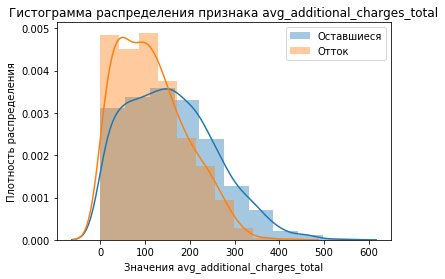

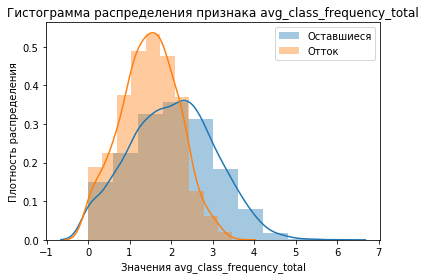

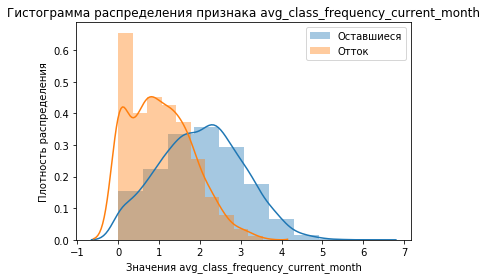

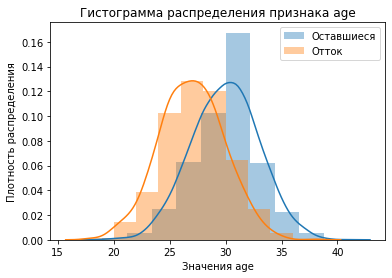

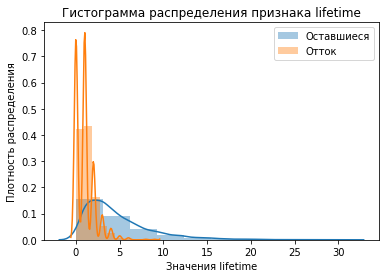

In [70]:
# выделяем датафреймы пользователей, которые остались клиентами и тех, что ушли (отток)
alive = data[data['churn']==0]
outflow = data[data['churn']==1]

# выделяем непрерывные величины в отдельный список
continuous = ['avg_additional_charges_total', 'avg_class_frequency_total', 'avg_class_frequency_current_month', 
              'age', 'lifetime']

# строим гистограммы распределения для списка continuous
for feature in continuous:
    plt.title(f"Гистограмма распределения признака {feature}")
    sns.distplot(alive[feature], bins=10, label='Оставшиеся')
    sns.distplot(outflow[feature], bins=10, label='Отток')
    plt.xlabel(f"Значения {feature}")
    plt.ylabel('Плотность распределения')
    plt.legend()
    plt.show()

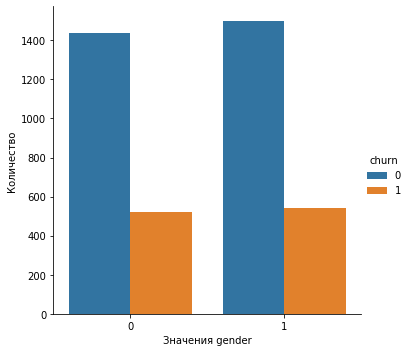

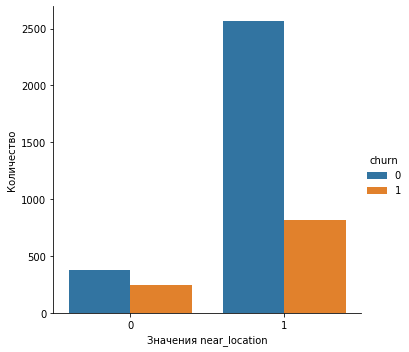

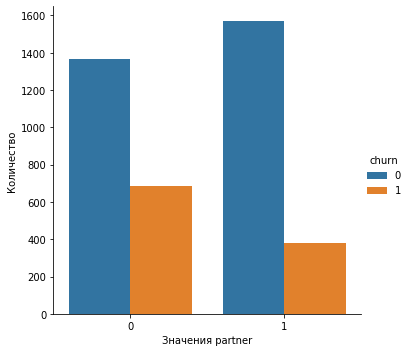

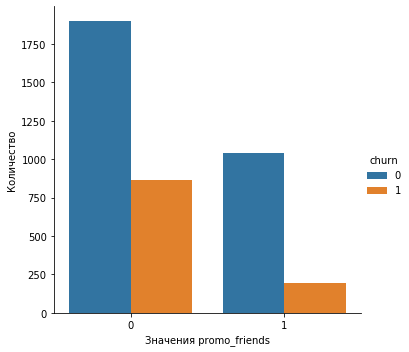

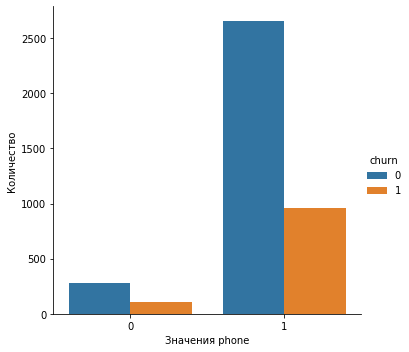

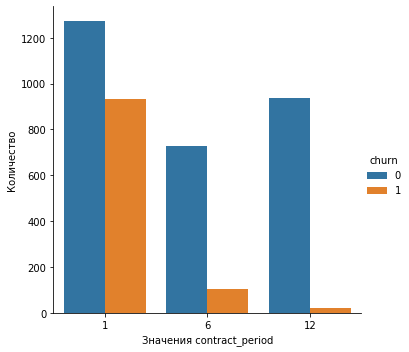

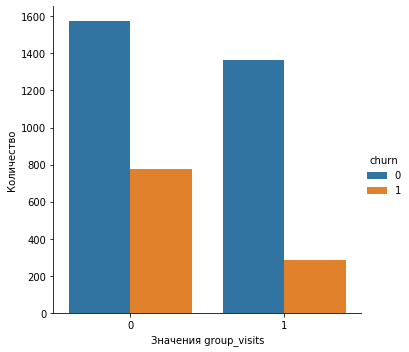

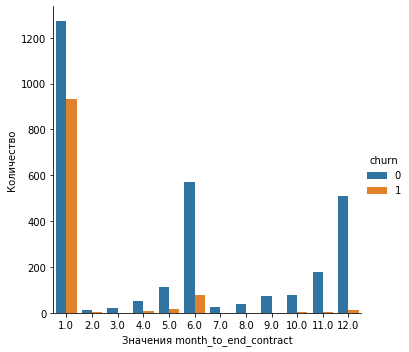

In [71]:
# выделяем дискретные величины в отдельный список
discrete = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'contract_period', 'group_visits',
            'month_to_end_contract']

# строим столбчатые диаграммы для списка discrete
for feature in discrete:
    #sns.barplot(x=feature, y=data[feature].count(), hue='churn', data=data)
    sns.catplot(data=data, x=feature, hue='churn', kind='count')
    plt.xlabel(f"Значения {feature}")
    plt.ylabel('Количество')
    plt.show()

По графикам можно сделать аналогичные выводы, что и в предыдущем пункте. Плюс добавить, что к оттоку склонны более молодые люди (около 27 лет).

### Матрица корреляций
<a id="analysis_4"></a>
Построим матрицу корреляций и отобразим её.

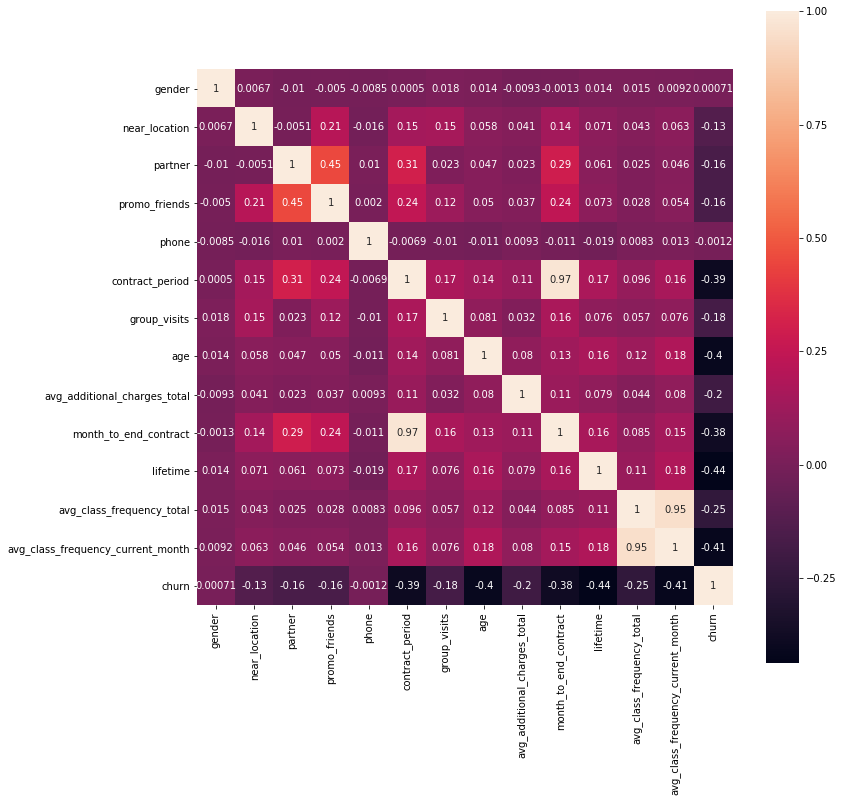

In [72]:
cm = data.corr()
fig, ax = plt.subplots(figsize=(12, 12))

sns.heatmap(cm, annot=True, square=True)
ax.set_ylim(14, 0)
plt.show()

Видим сильную корреляцию следующих признаков: contract_period и month_to_end_contract, а также avg_class_frequency_total и avg_class_frequency_current_month. Нужно учитывать это, так как некоторые модели неустойчивы в случае взаимной корреляции признаков. Нужно будет попробовать избавиться от одного из двух признаков с большой корреляцией, либо использовать регуляризацию.

### Вывод по данным
<a id="conclusion_1"></a>

1. Пропущенных значений и дубликатов в таблице не наблюдается. Названия столбцов были приведены к нижнему регистру.
2. В большей массе клиенты оставляют свой номер телефона (90%), живут где-то поблизости от клуба (почти 85%), 75% клиентов пришли относительно недавно (5 мес. назад и меньше), отток за последний месяц составил 26,5%.  У признаков  avg_additional_charges_total и lifetime есть max значения, похожие на выбросы.
3. По средним значениям признаков и графикам в разрезе тех, кто остался, и тех, кто ушел, выяснили:
* Уходит меньше клиентов, сотрудников компаний-партнеров клуба и пришедших по акции "приведи друга";
* Клиенты чаще уходят, если срок договора небольшой и если до конца договора остается меньше 2-ух месяцев;
* Если клиент не ходит на групповые занятия, то вероятность, что он уйдет больше;
* Клиенты, которые уходят, меньше тратили на дополнительные услуги клуба;
* К оттоку склонны более молодые люди (около 27 лет);
* Клиенты чаще уходят если с момента первого обращения в фитнес-центр прошел 1 месяц и при средней частоте посещения 1-2 раза в неделю.
4. Есть сильная корреляция следующих признаков: contract_period и month_to_end_contract, а также avg_class_frequency_total и avg_class_frequency_current_month. Предлагается обучить модели сначала со всеми признаками, а потом для обучения использовать из коррелирующих только month_to_end_contract и avg_class_frequency_current_month.

## Модель прогнозирования оттока клиентов
<a id="model"></a>
Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

### Разбиение на выборки
<a id="model_1"></a>
Разобьем данные изначального датасета на обучающую и валидационную выборки.

In [73]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop(columns=['churn'])
y = data['churn']

# делим выборку на train и test так, чтобы и в трейне и в тесте пропорция ушедших\оставшихся клиентов была одинаковой:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# применяем стандартизацию к матрице признаков для обучающей выборки
scaler = StandardScaler()
X_train_st = scaler.fit_transform(
    X_train
)  # обучаем scaler и одновременно трансформируем матрицу для обучающей выборки

# применяем стандартизацию к матрице признаков для тестовой выборки
X_test_st = scaler.transform(X_test)

###  Обучение моделей
<a id="model_2"></a>
Обучим модель на train-выборке двумя способами: логистической регрессией и случайным лесом.

In [74]:
# задаем список моделей
models = [
    LogisticRegression(solver='liblinear', random_state=0),
    RandomForestClassifier(n_estimators = 100, random_state = 0),
]

# функция обучения
def make_prediction(m, X_train, y_train, X_test, y_test):
    model = m
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred


### Оценка метрик на валидационной выборке
<a id="model_3"></a>
Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке.

In [75]:
# цикл, который выводит неоходимые метрики по списку моделей после вызова функции обучения и предсказания целевой переменной
for i in models:
    print(f"Метрики для {i}:")
    predictions = make_prediction(i, X_train_st, y_train, X_test_st, y_test)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    

Метрики для LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False):
Accuracy: 0.94
Precision: 0.90
Recall: 0.85
Метрики для RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
Accuracy: 0.92
Precision: 0.88
Recall: 0.83


### Обучение моделей без коррелирующих признаков
<a id="model_4"></a>
Проведем обучение моделей, но только перед этим удалив из пар коррелирующих признаков по одному столбцу, а потом сравним результат с тем, что выше.

In [76]:
# избавляемся от столбцов с высокой корреляцией и выделяем альтернативный датасет
data_alt = data.drop(['contract_period', 'avg_class_frequency_total'], axis=1)

# повтор процедуры по разделению выборки с альтернативным датасетом
X_alt = data_alt.drop(columns=['churn'])
y_alt = data_alt['churn']
X_train_alt, X_test_alt, y_train_alt, y_test_alt = train_test_split(X_alt, y_alt, test_size=0.2, random_state=0, stratify=y)
scaler = StandardScaler()
X_train_st_alt = scaler.fit_transform(X_train_alt)
X_test_st_alt = scaler.transform(X_test_alt)

for i in models:
    print(f"Метрики для {i}:")
    predictions = make_prediction(i, X_train_st_alt, y_train_alt, X_test_st_alt, y_test_alt)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test_alt, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test_alt, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test_alt, predictions)))

Метрики для LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False):
Accuracy: 0.92
Precision: 0.84
Recall: 0.84
Метрики для RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False):
Accuracy: 0.91
Precision: 0.85
Recall: 0.80


За счет более высоких показателей метрик выбираем модель логистической регрессии без удаления коррелирующих признаков.

### Вес признаков
<a id="model_5"></a>
Определим веса признаков для выбранной модели.

In [77]:
import statsmodels.api as sm

model = LogisticRegression(solver='liblinear', random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)

# создадим датафрейм с признаками и их весами
df = pd.DataFrame(model.coef_)
df = df.T.abs()
df = df.rename(columns = {0 : 'importance'})
df['feature'] = X.columns

# выведим упорядоченный по модулю коэффициентов датафрейм с признаками
print(df.sort_values(by = 'importance', ascending = False))

    importance                            feature
12    4.189012  avg_class_frequency_current_month
10    3.471939                           lifetime
11    3.105587          avg_class_frequency_total
7     1.148928                                age
5     0.687710                    contract_period
9     0.617235              month_to_end_contract
8     0.560866       avg_additional_charges_total
6     0.393328                       group_visits
3     0.139599                      promo_friends
2     0.068231                            partner
1     0.052630                      near_location
4     0.021564                              phone
0     0.006316                             gender


### Вывод по моделям
<a id="conclusion_2"></a>
Модели логистической регрессии и случайного леса показали близкие результаты, лучше всего ведет себя модель логистической регрессии с учетом всех признаков. Определили, у каких признаков больше влияния на целевую переменную для выбранной модели, это: 
* avg_class_frequency_current_month (средняя частота посещений в неделю за предыдущий месяц), 
* lifetime (время с момента первого обращения в фитнес-центр),
* avg_class_frequency_total (средняя частота посещений в неделю за все время),
* age (возраст).

## Кластеризация клиентов
<a id="cluster"></a>
Проведем кластеризацию объектов (клиентов).

### Стандартизация данных
<a id="cluster_1"></a>
Стандартизируем все данные, за исключением столбца с оттоком.

In [78]:
sc = StandardScaler()
# обучаем нормализатор и преобразуем набор данных к стандартизованному виду
x_sc = sc.fit_transform(data.drop(columns=['churn']))

### Матрица расстояний и дендрограмма
<a id="cluster_2"></a>
Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.

In [79]:
# вычисляем матрицу расстояний между всеми объектами
linked = linkage(x_sc, method = 'ward')

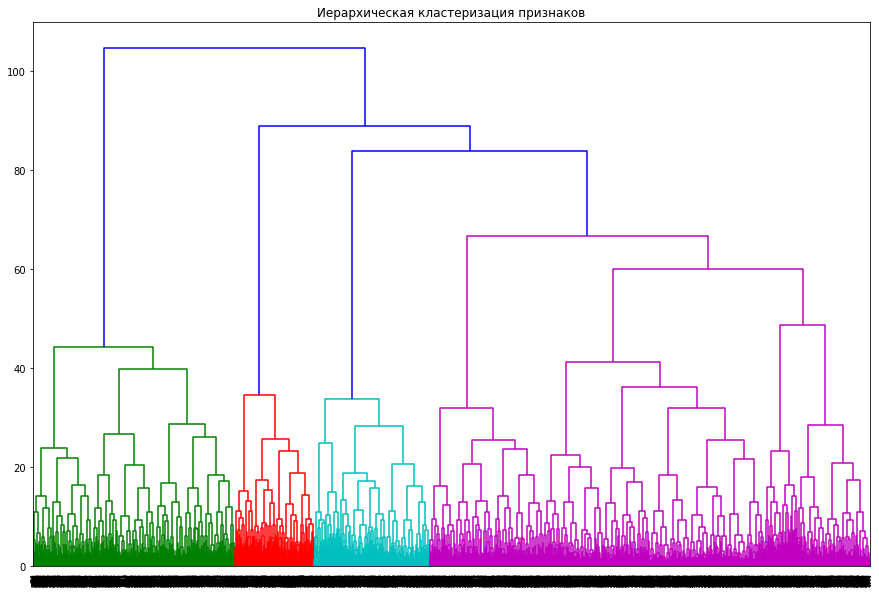

In [80]:
# строим дендрограмму
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Иерархическая кластеризация признаков')
plt.show()

Судя по графику оптимальное число кластеров 4 — четыре разных цвета на графике.

### Обучение модели кластеризации
<a id="cluster_3"></a>
Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.За число кластеров принимаем n=4.

In [81]:
km = KMeans(n_clusters=4, random_state=0)
# применяем алгоритм к данным и формируем вектор кластеров (присваивание им номера от 0 до 4)
labels = km.fit_predict(x_sc)

In [82]:
# сохраняем метки кластера в поле нашего исходного датасета
data['cluster'] = labels

### Средние значения признаков для кластеров и доли оттока
<a id="cluster_4"></a>
Посмотрим на средние значения признаков для кластеров и доли оттока по ним.

In [83]:
# выводим статистику по средним значениям наших признаков по кластеру
data.groupby('cluster').mean().round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
cluster,,,,,,,,,,,,,,
0,0.52,0.86,0.47,0.31,0.0,4.78,0.43,29.30,144.21,4.47,3.94,1.85,1.72,0.27
1,0.49,0.76,0.38,0.19,1.0,1.90,0.29,28.05,129.70,1.81,2.24,1.20,0.95,0.56
2,0.54,0.86,0.34,0.21,1.0,2.40,0.45,29.99,157.36,2.24,4.70,2.72,2.71,0.09
3,0.50,0.94,0.78,0.57,1.0,10.70,0.54,29.91,161.36,9.77,4.73,1.98,1.98,0.03


Можно заметить следующее:
1. Самый большой отток по кластеру 1 (56%), в этом кластере самый молодой средний возраст, клиенты там меньше тратят на доп. услуги клуба, пришли в клуб недавно, договор на посещения закончится меньше чем через 2 мес., посещение в среднем 1 раз в неделю.
2. Следующий по оттоку кластер 0 (27%), там никто не оставлял номер телефона и ходят в клуб менее 2-ух раз в неделю в среднем.
3. По кластеру 2 небольшой отток, часто ходят в клуб (почти 3 раза в неделю), самые возрастные, много тратят на доп. услуги.
4. По кластеру 3 небольшой отток, среди них в основном клиенты со стороны партнерских организаций и пришедщих по акции "приведи друга", с большим сроком контракта, много тратят на доп. услуги, ходят стабильно 2 раза в неделю в среднем.

### Распределения признаков для кластеров
<a id="cluster_4"></a>
Построим и проанализируем распределения признаков для кластеров.

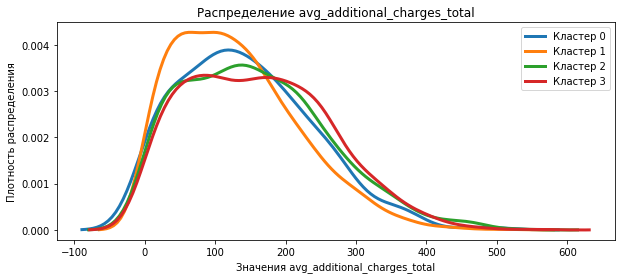

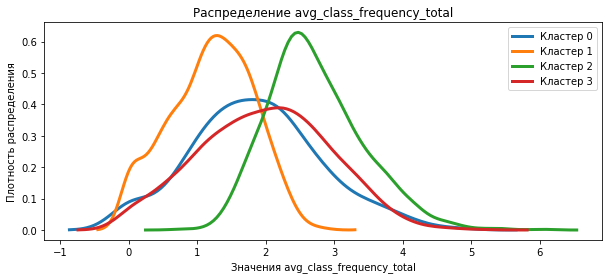

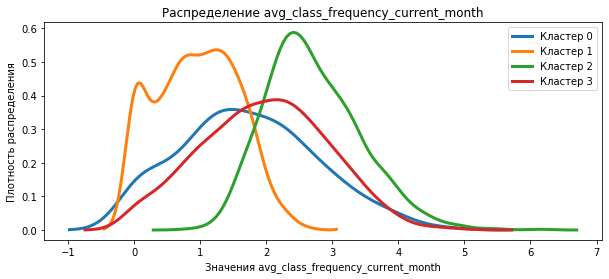

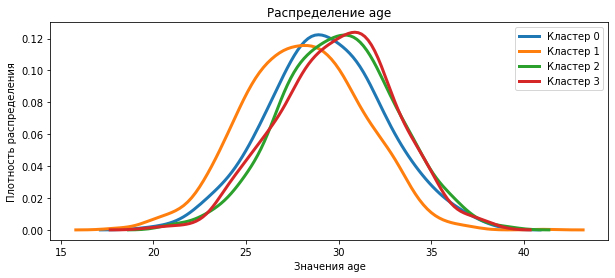

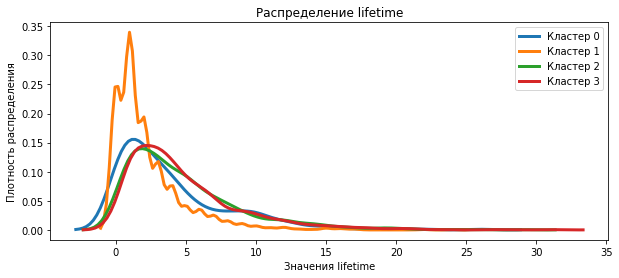

In [84]:
# непрерывные величины в отдельном списке
continuous_new = ['avg_additional_charges_total', 'avg_class_frequency_total', 
                  'avg_class_frequency_current_month', 'age', 'lifetime']
# вывод графиков
for col in continuous_new:
    plt.figure(figsize=(10,4))
    for i in range(0,5):
        plt.title(f"Распределение {col}")
        sns.distplot(data.query('cluster == @i')[col],
                     hist=False,
                     kde_kws={'label':'Кластер'+' '+str(i), 'lw':3})
    plt.xlabel(f"Значения {col}")
    plt.ylabel('Плотность распределения')
    plt.legend()
plt.show()
        

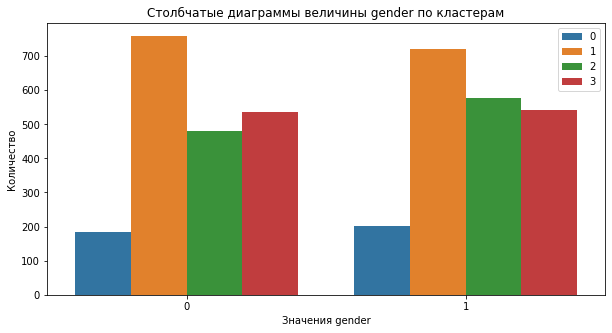

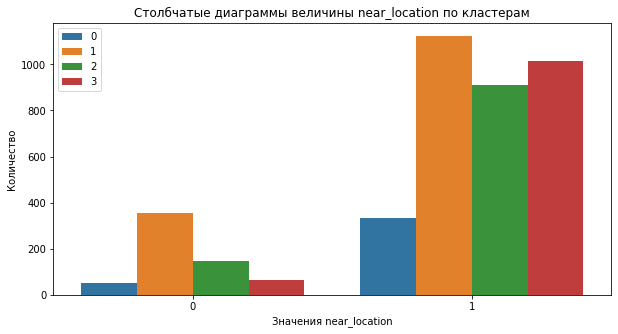

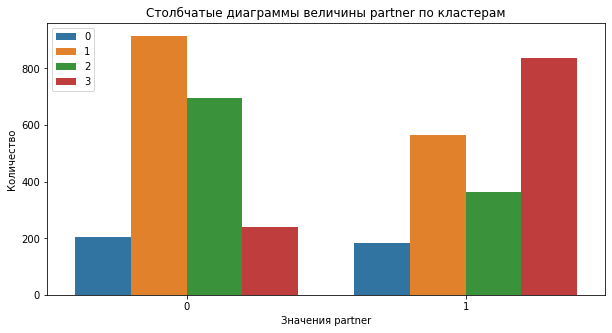

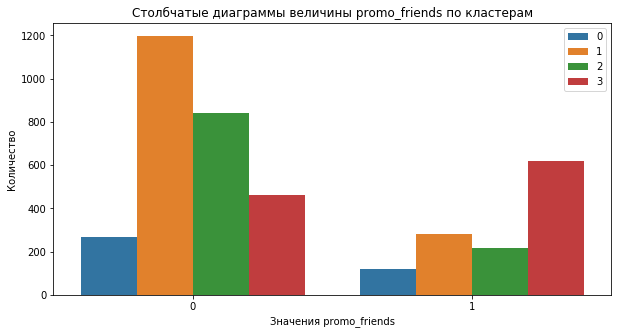

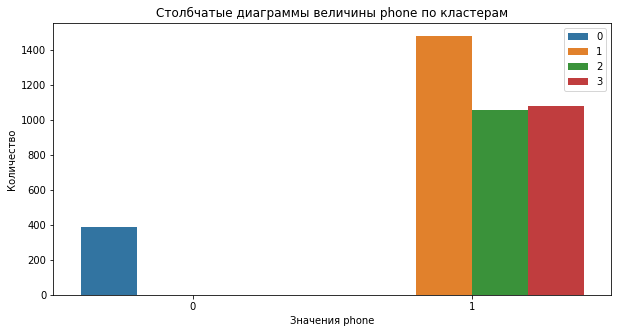

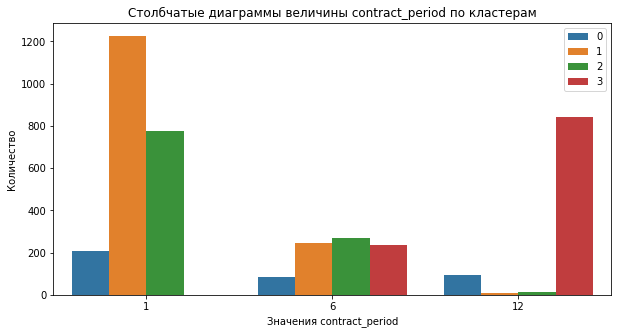

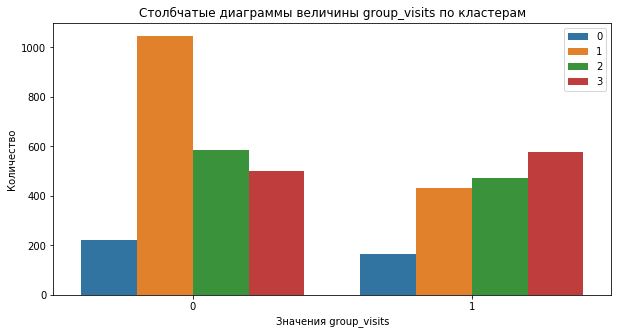

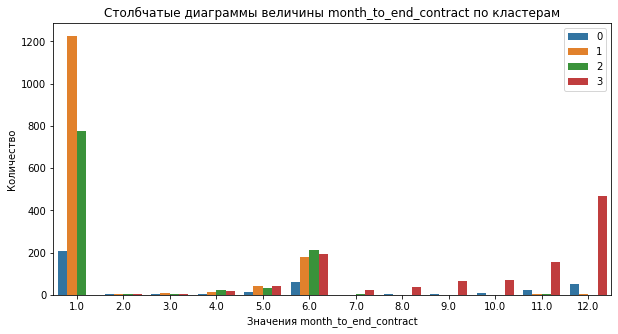

In [85]:
# дискретные величины в отдельном списке
discrete_new = ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
                'contract_period', 'group_visits', 'month_to_end_contract']
# вывод графиков
for col in discrete_new:
    plt.figure(figsize=(10,5))
    plt.title(f"Столбчатые диаграммы величины {col} по кластерам")
    sns.countplot(x=col, data=data, hue='cluster')
    plt.xlabel(f"Значения {col}")
    plt.ylabel('Количество')
    plt.legend()
plt.show()


Графики по сути подтверждают наблюдения указанные в предыдущем пункте.

## Выводы и рекомендации
<a id="conclusion"></a>
Было проведено исследование признаков клиентской базы сети фитнес-центров и их влияния на отток.
Выводы по исследованию:
1. Отток в последнем месяце достаточно большой - 26.5%.
2. Такие признаки, как пол клиента и близость проживания к клубу, меньше всего оказывают влияние на отток, и никак не выделяются при сегментации клиентов.
3. Для прогноза оттока клиентов была выбрана модель логистической регрессии (LogisticRegression). Ее доля правильных ответов 94% на валидационной выборке.
4. Наибольшее влияние на отток согласно выбранной модели оказывают признаки:
* средняя частота посещений в неделю за предыдущий месяц,
* время с момента первого обращения в фитнес-центр,
* средняя частота посещений в неделю за все время,
* возраст.

5. После кластеризации клиентов выделили 4 группы. Наибольший отток по 2-ум кластерам:
* Кластеру 1 (отток 56%): в этом кластере самый молодой средний возраст (28 лет), клиенты там меньше тратят на доп. услуги клуба, пришли в клуб недавно, договор на посещения закончится меньше чем через 2 мес., посещение в среднем 1 раз в неделю.
* Кластер 0 (отток 27%), люди которые не оставляли номер телефона и ходят в клуб менее 2-ух раз в неделю в среднем.

  По кластеру 1 видим почти полное совпадение наиболее влияющих признаков с тем, что определили через модель предсказания выше.
    
Рекомендации по взаимодействию с клиентами и их удержанию:
1. Присылать напоминания на телефон о том, как хорошо заниматься в клубе или о новых возможностях, если клиент ходит менее 2-ух раз в неделю в последний месяц.
2. Продумать систему скидок для тех, кто ходит в клуб от 3-6 месяцев, например.
3. Продумать накопительную систему бонусных баллов для того, чтоб стимулировать покупку доп. услуг. 
4. Присылать напоминания на телефон, стимулирующие продление договора, если срок окончания текущего договора менее 2 мес.
5. Предложить месяц посещения центра в подарок для тех, кто не оставлял номера телефона, если они оставят телефон.